In [1]:
import numpy as np 
import pandas as pd 
import os
from sklearn.metrics import confusion_matrix
import numpy as np

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax
from keras.layers import Input, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Embedding, Add, MaxPool1D,ZeroPadding1D, LSTM
from keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers
from keras.models import Sequential, Model


from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

import seaborn as sns
from sklearn.metrics import confusion_matrix


%matplotlib inline

In [2]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec


In [3]:
path = 'C:/Users/mahfo/Downloads/btp_data/mitbih_database/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'S', 'F', 'V', 'Q']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [4]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

In [5]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:57: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:57: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\mahfo\AppData\Local\Temp\ipykernel_17288\3133449120.py:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:
C:\Users\mahfo\AppData\Local\Temp\ipykernel_17288\3133449120.py:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:
C:\Users\mahfo\AppData\Local\Temp\ipykernel_17288\3133449120.py:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:
C:\Users\mahfo\AppData\Local\Temp\ipykernel_17288\3133449120.py:57: SyntaxWarning: "is" with a l

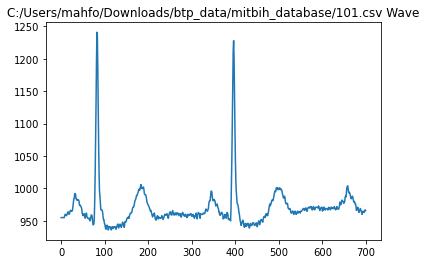

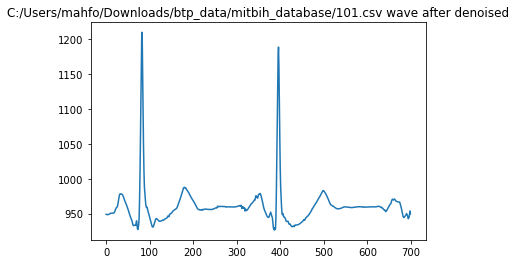

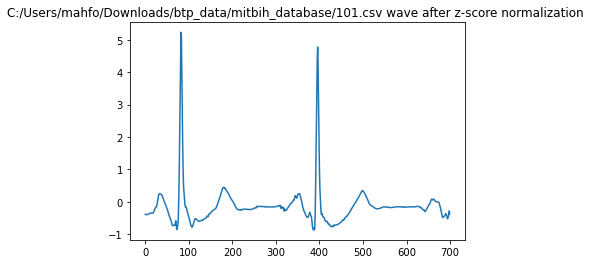

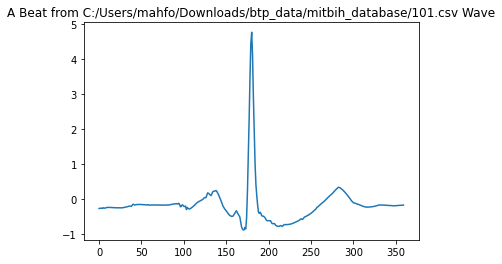

(82977, 360) (82977,)


In [6]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = denoise(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
#                 if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
#                     pass
#                 else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r is 1 and not example_beat_printed: 
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))


In [7]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))

(82977, 361)


0.0    75011
3.0     7129
2.0      802
4.0       33
1.0        2
Name: 360, dtype: int64


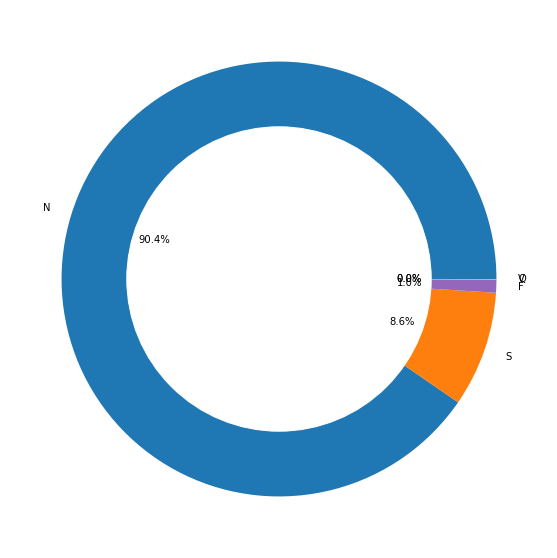

In [8]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'S', 'F', 'V', 'Q'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [9]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

0.0    5000
1.0    5000
2.0    5000
3.0    5000
4.0    5000
Name: 360, dtype: int64


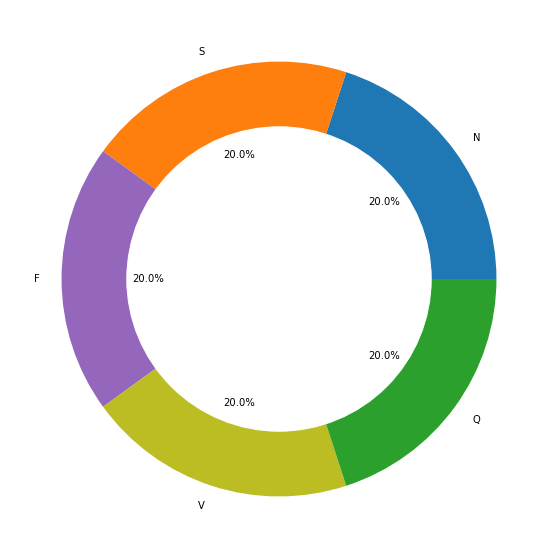

In [10]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'S', 'F', 'V', 'Q'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [11]:
train, test = train_test_split(X_train_df, test_size=0.20)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (20000, 361)
X_test  :  (5000, 361)


In [12]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(20000, 5) (5000, 5)


In [13]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

(20000, 360, 1) (5000, 360, 1)


In [14]:
# Instanciate an empty model
model = Sequential()

# Adding a Convolution Layer C1
# Input shape = N = (360 x 1)
# No. of filters  = 16
# Filter size = f = (13 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 360-13+2*6 +1 = 360
# No. of parameters between input layer and C1 = (13*1 + 1)*16 = 224
model.add(Conv1D(filters=16, kernel_size=13, padding='same', activation='relu',input_shape=(360, 1)))


# Adding an Average Pooling Layer S2
# Input shape = N = (360 x 16)
# No. of filters = 16
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (360-3+0+1)/2 = 179
# No. of parameters between C1 and S2 = (1+1)*16 = 32
model.add(AvgPool1D(pool_size=3, strides=2))





# Adding a Convolution Layer C3
# Input shape = N = (179 x 16)
# No. of filters  = 32
# Filter size = f = (15 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 179-15+2*7 +1 = 360
# No. of parameters between input layer and C1 = (15*1 + 1)*32 = 512
model.add(Conv1D(filters=32, kernel_size=15, padding='same', activation='relu'))


# Adding an Average Pooling Layer S4
# Input shape = N = (179 x 32)
# No. of filters = 32
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (179-3+0+1)/2 = 89
# No. of parameters between C1 and S2 = (1+1)*32 = 64
model.add(AvgPool1D(pool_size=3, strides=2))



# Adding a Convolution Layer C5
# Input shape = N = (89 x 32)
# No. of filters  = 64
# Filter size = f = (17 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 89-17+2*8 +1 = 89
# No. of parameters between input layer and C1 = (17*1 + 1)*64 = 1152
model.add(Conv1D(filters=64, kernel_size=17, padding='same', activation='relu'))



# Adding an Average Pooling Layer S6
# Input shape = N = (89 x 64)
# No. of filters = 64
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (89-3+0+1)/2 = 44
# No. of parameters between C1 and S2 = (1+1)*64 = 128
model.add(AvgPool1D(pool_size=3, strides=2))



# Adding a Convolution Layer C7
# Input shape = N = (44 x 64)
# No. of filters  = 128
# Filter size = f = (19 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 44-19+2*9 +1 = 44
# No. of parameters between input layer and C1 = (19*1 + 1)*128 = 2560
model.add(Conv1D(filters=128, kernel_size=19, padding='same', activation='relu'))


# Adding an Average Pooling Layer S8
# Input shape = N = (44 x 128)
# No. of filters = 128
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (44-3+0+1)/2 = 21
# No. of parameters between C1 and S2 = (1+1)*128 = 256
model.add(AvgPool1D(pool_size=3, strides=2))



# Flattening the layer 
# There would be 128*(21*1) = 2688 neurons
model.add(Flatten())


# Dropout the layer S9
model.add(Dropout(0.5))



# Adding a Dense layer with regularization l2(0.0001)# S10
# No. of inputs = 2688
# No. of outputs = 35
# No. of parameters = 2688 x 35 + 35 = 94115
model.add(Dense(35,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))



# Adding a Dense layer with regularization l2(0.0001)# S11
# No. of inputs = 35
# No. of outputs = 5
# No. of parameters = 35*5 + 5 = 180
model.add(Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))



# Adding a Softmax layer S12
# No. of inputs = 5
# No. of outputs = 5
model.add(Softmax())


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 360, 16)           224       
                                                                 
 average_pooling1d (AverageP  (None, 179, 16)          0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 179, 32)           7712      
                                                                 
 average_pooling1d_1 (Averag  (None, 89, 32)           0         
 ePooling1D)                                                     
                                                                 
 conv1d_2 (Conv1D)           (None, 89, 64)            34880     
                                                                 
 average_pooling1d_2 (Averag  (None, 44, 64)           0

In [15]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [16]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [17]:
history_cnn = model.fit(train_x, train_y, batch_size=30, epochs=5, verbose=1, validation_data=(test_x, test_y))

Epoch 1/5
667/667 [==============================] - 23s 32ms/step - loss: 0.2753 - accuracy: 0.9071 - val_loss: 0.1281 - val_accuracy: 0.9572
Epoch 2/5
667/667 [==============================] - 20s 29ms/step - loss: 0.1307 - accuracy: 0.9585 - val_loss: 0.1086 - val_accuracy: 0.9684
Epoch 3/5
667/667 [==============================] - 19s 29ms/step - loss: 0.1021 - accuracy: 0.9697 - val_loss: 0.0961 - val_accuracy: 0.9762
Epoch 4/5
667/667 [==============================] - 20s 29ms/step - loss: 0.0936 - accuracy: 0.9732 - val_loss: 0.0702 - val_accuracy: 0.9808
Epoch 5/5
667/667 [==============================] - 19s 29ms/step - loss: 0.0780 - accuracy: 0.9779 - val_loss: 0.0590 - val_accuracy: 0.9840


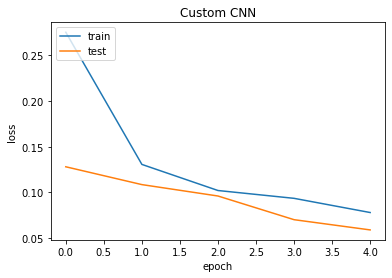

<Figure size 432x288 with 0 Axes>

In [18]:
# summarize history for loss
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Custom CNN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('cusCNNloss.png')

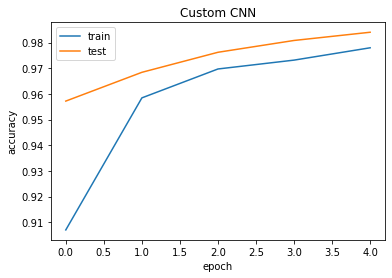

<Figure size 432x288 with 0 Axes>

In [19]:
# summarize history for accuracy
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Custom CNN')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('CustCnnAcc.png')

In [20]:
y_true=[]
for element in test_y:
    y_true.append(np.argmax(element))
prediction_proba=model.predict(test_x)
prediction=np.argmax(prediction_proba,axis=1)

157/157 [==============================] - 1s 8ms/step


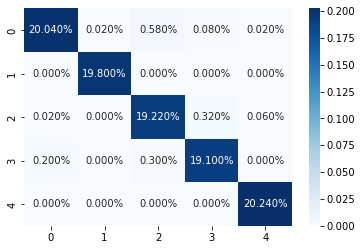

In [21]:
custCnnConfMat = confusion_matrix(y_true, prediction)
sns.heatmap(custCnnConfMat/np.sum(custCnnConfMat), annot=True,fmt='.3%', cmap='Blues')
plt.savefig('custCnnconfMat.png')

In [22]:
print('Precision: %.3f' % precision_score(y_true, prediction, average='weighted'))
print('F1 Score: %.3f' % f1_score(y_true, prediction, average='macro'))
print('Recall: %.3f' % recall_score(y_true, prediction, average='micro'))
print('Accuracy: %.3f' % accuracy_score(y_true, prediction))


Precision: 0.984
F1 Score: 0.984
Recall: 0.984
Accuracy: 0.984


In [23]:
alexNet_model=Sequential()

alexNet_model.add(Conv1D(filters=96, activation='relu', kernel_size=11, strides=4, input_shape=(360,1)))
alexNet_model.add(BatchNormalization())
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Conv1D(filters=256, kernel_size=5, padding='same', activation='relu'))
alexNet_model.add(BatchNormalization())
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Conv1D(filters=384, padding='same', kernel_size=3, activation='relu'))
alexNet_model.add(Conv1D(filters=384, kernel_size=3, activation='relu'))
alexNet_model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
alexNet_model.add(BatchNormalization())
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Flatten())
alexNet_model.add(Dense(4096, activation='relu'))
alexNet_model.add(Dropout(0.4))
alexNet_model.add(Dense(4096, activation='relu'))
alexNet_model.add(Dropout(0.4))
alexNet_model.add(Dense(5, activation='softmax'))

In [24]:
alexNet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 88, 96)            1152      
                                                                 
 batch_normalization (BatchN  (None, 88, 96)           384       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 44, 96)           0         
 )                                                               
                                                                 
 conv1d_5 (Conv1D)           (None, 44, 256)           123136    
                                                                 
 batch_normalization_1 (Batc  (None, 44, 256)          1024      
 hNormalization)                                                 
                                                      

In [25]:
plot_model(alexNet_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [26]:
alexNet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
alexNet_model_history = alexNet_model.fit(train_x, train_y, epochs = 5, batch_size = 30, validation_data = (test_x, test_y))

Epoch 1/5
667/667 [==============================] - 163s 242ms/step - loss: 0.4171 - accuracy: 0.9032 - val_loss: 0.3202 - val_accuracy: 0.9198
Epoch 2/5
667/667 [==============================] - 160s 240ms/step - loss: 0.2117 - accuracy: 0.9396 - val_loss: 0.1635 - val_accuracy: 0.9492
Epoch 3/5
667/667 [==============================] - 166s 248ms/step - loss: 0.1618 - accuracy: 0.9499 - val_loss: 0.1270 - val_accuracy: 0.9662
Epoch 4/5
667/667 [==============================] - 164s 245ms/step - loss: 0.1398 - accuracy: 0.9589 - val_loss: 0.2691 - val_accuracy: 0.9528
Epoch 5/5
667/667 [==============================] - 162s 243ms/step - loss: 0.1818 - accuracy: 0.9514 - val_loss: 0.0757 - val_accuracy: 0.9736


In [28]:
y_true_alexnet=[]
for element in test_y:
    y_true_alexnet.append(np.argmax(element))
prediction_proba=alexNet_model.predict(test_x)
prediction_alexnet=np.argmax(prediction_proba,axis=1)

157/157 [==============================] - 5s 29ms/step


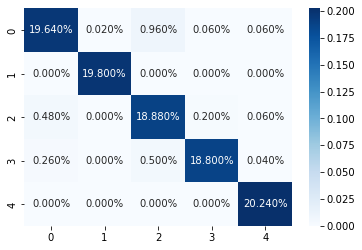

In [29]:
alexnetConfMat = confusion_matrix(y_true_alexnet, prediction_alexnet)
sns.heatmap(alexnetConfMat/np.sum(alexnetConfMat), annot=True,fmt='.3%', cmap='Blues')
plt.savefig('custCnnconfMat.png')

In [30]:
print('Precision: %.3f' % precision_score(y_true_alexnet, prediction_alexnet, average='micro'))
print('F1 Score: %.3f' % f1_score(y_true_alexnet, prediction_alexnet, average='micro'))
print('Recall: %.3f' % recall_score(y_true_alexnet, prediction_alexnet, average='micro'))
print('Accuracy: %.3f' % accuracy_score(y_true_alexnet, prediction_alexnet))


Precision: 0.974
F1 Score: 0.974
Recall: 0.974
Accuracy: 0.974


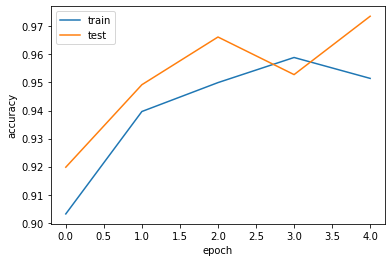

<Figure size 432x288 with 0 Axes>

In [31]:
plt.plot(alexNet_model_history.history['accuracy'])
plt.plot(alexNet_model_history.history['val_accuracy'])
#plt.title('Custom CNN')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('AlexNetAccuracy.png')

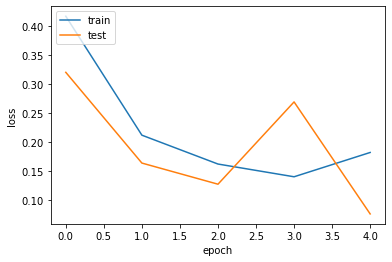

<Figure size 432x288 with 0 Axes>

In [32]:
plt.plot(alexNet_model_history.history['loss'])
plt.plot(alexNet_model_history.history['val_loss'])
#plt.title('Custom CNN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('AlexNetLoss.png')

In [33]:
vgg_16_model=Sequential()

vgg_16_model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu',  input_shape=(360,1)))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Conv1D(filters=512, kernel_size=1, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Conv1D(filters=512, kernel_size=1, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Flatten())
vgg_16_model.add(Dense(4096, activation='relu'))
vgg_16_model.add(Dropout(0.4))
vgg_16_model.add(Dense(4096, activation='relu'))
vgg_16_model.add(Dropout(0.4))
vgg_16_model.add(Dense(5, activation='softmax'))

In [34]:
plot_model(vgg_16_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [35]:
vgg_16_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 360, 64)           256       
                                                                 
 batch_normalization_3 (Batc  (None, 360, 64)          256       
 hNormalization)                                                 
                                                                 
 conv1d_10 (Conv1D)          (None, 360, 64)           12352     
                                                                 
 batch_normalization_4 (Batc  (None, 360, 64)          256       
 hNormalization)                                                 
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 180, 64)          0         
 1D)                                                             
                                                      

In [36]:
vgg_16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
vgg_16_model_history = vgg_16_model.fit(train_x, train_y, epochs = 5, batch_size = 40, validation_data = (test_x, test_y))

Epoch 1/5
500/500 [==============================] - 485s 964ms/step - loss: 1.0024 - accuracy: 0.8555 - val_loss: 0.4167 - val_accuracy: 0.9108
Epoch 2/5
500/500 [==============================] - 459s 917ms/step - loss: 0.5001 - accuracy: 0.9129 - val_loss: 0.2904 - val_accuracy: 0.9340
Epoch 3/5
500/500 [==============================] - 463s 927ms/step - loss: 0.2603 - accuracy: 0.9308 - val_loss: 0.1997 - val_accuracy: 0.9442
Epoch 4/5
500/500 [==============================] - 457s 914ms/step - loss: 0.1919 - accuracy: 0.9448 - val_loss: 0.1752 - val_accuracy: 0.9546
Epoch 5/5
500/500 [==============================] - 454s 909ms/step - loss: 0.1656 - accuracy: 0.9516 - val_loss: 0.1057 - val_accuracy: 0.9700


In [39]:
y_true_vgg=[]
for element in test_y:
    y_true_vgg.append(np.argmax(element))
prediction_proba=vgg_16_model.predict(test_x)
prediction_vgg16=np.argmax(prediction_proba,axis=1)

157/157 [==============================] - 16s 101ms/step


Accuracy: 0.970


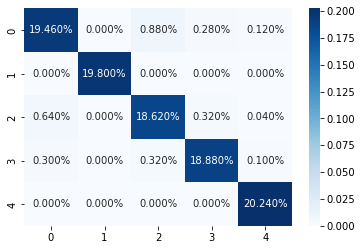

In [40]:
vggconfmat = confusion_matrix(y_true_vgg, prediction_vgg16)
sns.heatmap(vggconfmat/np.sum(vggconfmat), annot=True,fmt='.3%', cmap='Blues')
plt.savefig('vgg16ConfMat.png')
print('Accuracy: %.3f' % accuracy_score(y_true_vgg, prediction_vgg16))

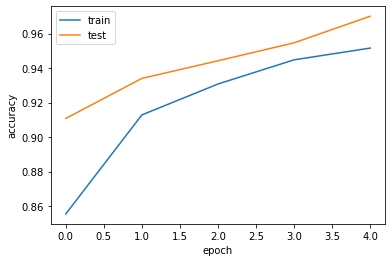

<Figure size 432x288 with 0 Axes>

In [41]:
# summarize history for accuracy
plt.plot(vgg_16_model_history.history['accuracy'])
plt.plot(vgg_16_model_history.history['val_accuracy'])
#plt.title('Custom CNN')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('vgg16Accuracy.png')

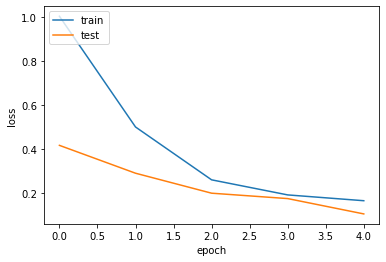

<Figure size 432x288 with 0 Axes>

In [42]:
plt.plot(vgg_16_model_history.history['loss'])
plt.plot(vgg_16_model_history.history['val_loss'])
#plt.title('Custom CNN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('vgg16Loss.png')

In [43]:
def identity_block(X, f, filters):
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv1D(filters = F1, kernel_size = 1, activation='relu', strides = 1, padding = 'valid')(X)
    X = BatchNormalization()(X)
    
    X = Conv1D(filters = F2, kernel_size = f, activation='relu', strides = 1, padding = 'same')(X)
    X = BatchNormalization()(X)

    X = Conv1D(filters = F3, kernel_size = 1, activation='relu', strides = 1, padding = 'valid')(X)
    X = BatchNormalization()(X)

    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [44]:
def convolutional_block(X, f, filters, s = 2):
    F1, F2, F3 = filters
    
    X_shortcut = X

    X = Conv1D(F1, 1, activation='relu', strides = s)(X)
    X = BatchNormalization()(X)
    
    X = Conv1D(F2, f, activation='relu', strides = 1,padding = 'same')(X)
    X = BatchNormalization()(X)

    X = Conv1D(F3, 1, strides = 1)(X)
    X = BatchNormalization()(X)

    X_shortcut = Conv1D(F3, 1, strides = s)(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)
    
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [45]:
def ResNet50(input_shape = (360,1)):
    
    X_input = Input(input_shape)

    X = ZeroPadding1D(3)(X_input)
    
    X = Conv1D(64, 7, activation='relu', strides = 2)(X)
    X = BatchNormalization()(X)
    X = MaxPool1D(pool_size=2, strides=2, padding='same')(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2)
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])

    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    X = MaxPool1D(pool_size=2, strides=2, padding='same')(X)
    
    X = Flatten()(X)
    X = Dense(5,activation='softmax')(X)
    
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [46]:
resNet50_model = ResNet50(input_shape = (360,1))

In [47]:
resNet50_model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 360, 1)]     0           []                               
                                                                                                  
 zero_padding1d (ZeroPadding1D)  (None, 366, 1)      0           ['input_1[0][0]']                
                                                                                                  
 conv1d_22 (Conv1D)             (None, 180, 64)      512         ['zero_padding1d[0][0]']         
                                                                                                  
 batch_normalization_16 (BatchN  (None, 180, 64)     256         ['conv1d_22[0][0]']              
 ormalization)                                                                             

                                                                                                  
 conv1d_34 (Conv1D)             (None, 45, 128)      49280       ['batch_normalization_27[0][0]'] 
                                                                                                  
 batch_normalization_28 (BatchN  (None, 45, 128)     512         ['conv1d_34[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_35 (Conv1D)             (None, 45, 512)      66048       ['batch_normalization_28[0][0]'] 
                                                                                                  
 conv1d_36 (Conv1D)             (None, 45, 512)      131584      ['activation_2[0][0]']           
                                                                                                  
 batch_nor

 batch_normalization_40 (BatchN  (None, 23, 256)     1024        ['conv1d_46[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_47 (Conv1D)             (None, 23, 256)      196864      ['batch_normalization_40[0][0]'] 
                                                                                                  
 batch_normalization_41 (BatchN  (None, 23, 256)     1024        ['conv1d_47[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_48 (Conv1D)             (None, 23, 1024)     263168      ['batch_normalization_41[0][0]'] 
                                                                                                  
 conv1d_49

 conv1d_59 (Conv1D)             (None, 23, 256)      262400      ['activation_10[0][0]']          
                                                                                                  
 batch_normalization_53 (BatchN  (None, 23, 256)     1024        ['conv1d_59[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_60 (Conv1D)             (None, 23, 256)      196864      ['batch_normalization_53[0][0]'] 
                                                                                                  
 batch_normalization_54 (BatchN  (None, 23, 256)     1024        ['conv1d_60[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_61

 activation_14 (Activation)     (None, 12, 2048)     0           ['add_14[0][0]']                 
                                                                                                  
 conv1d_72 (Conv1D)             (None, 12, 512)      1049088     ['activation_14[0][0]']          
                                                                                                  
 batch_normalization_66 (BatchN  (None, 12, 512)     2048        ['conv1d_72[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_73 (Conv1D)             (None, 12, 512)      786944      ['batch_normalization_66[0][0]'] 
                                                                                                  
 batch_normalization_67 (BatchN  (None, 12, 512)     2048        ['conv1d_73[0][0]']              
 ormalizat

In [48]:
plot_model(resNet50_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [49]:
resNet50_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
resNet50_model_history = resNet50_model.fit(train_x, train_y, epochs = 5, batch_size = 30, validation_data = (test_x, test_y))

Epoch 1/5
667/667 [==============================] - 831s 1s/step - loss: 0.8254 - accuracy: 0.9279 - val_loss: 0.1356 - val_accuracy: 0.9562
Epoch 2/5
667/667 [==============================] - 844s 1s/step - loss: 0.5415 - accuracy: 0.9290 - val_loss: 0.7821 - val_accuracy: 0.9320
Epoch 3/5
667/667 [==============================] - 860s 1s/step - loss: 0.3362 - accuracy: 0.9488 - val_loss: 0.2869 - val_accuracy: 0.9454
Epoch 4/5
355/667 [==============>...............] - ETA: 6:41 - loss: 0.5546 - accuracy: 0.9443

In [ ]:
plt.plot(resNet50_model_history.history['accuracy'])
plt.plot(resNet50_model_history.history['val_accuracy'])
plt.legend(["accuracy","val_accuracy"])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ResNet')
plt.savefig('ResNetAccuracy.png')

In [ ]:
plt.plot(resNet50_model_history.history['loss'])
plt.plot(resNet50_model_history.history['val_loss'])
plt.legend(["loss","val_loss"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet')
plt.savefig('ResNetLoss.png')

In [ ]:
y_true_resnet=[]
for element in test_y:
    y_true_resnet.append(np.argmax(element))
prediction_proba=resNet50_model.predict(test_x)
prediction_resnet=np.argmax(prediction_proba,axis=1)

In [ ]:
resNet50_model_cf_matrix = confusion_matrix(y_true_resnet, prediction_resnet)
sns.heatmap(resNet50_model_cf_matrix/np.sum(resNet50_model_cf_matrix), annot=True,fmt='.3%', cmap='Blues')
plt.title('ResNet')
plt.savefig('ResNetConfMat.png')

In [ ]:
print('Precision: %.3f' % precision_score(y_true_resnet, prediction_resnet, average='micro'))
print('F1 Score: %.3f' % f1_score(y_true_resnet, prediction_resnet, average='micro'))
print('Recall: %.3f' % recall_score(y_true_resnet, prediction_resnet, average='micro'))
print('Accuracy: %.3f' % accuracy_score(y_true_resnet, prediction_resnet))

In [ ]:
import numpy as np
from scipy.stats import mode
pred_vgg16 = to_categorical(prediction_vgg16, num_classes=5)
pred_alexnet = to_categorical(prediction_alexnet, num_classes=5)
pred_resnet = to_categorical(prediction_resnet, num_classes=5)
class_labels_vgg16 = np.argmax(pred_vgg16, axis=1)
class_labels_alexnet = np.argmax(pred_alexnet, axis=1)
class_labels_resnet = np.argmax(pred_resnet, axis=1)

# Create an ensemble by taking the majority vote
ensemble_class_labels = mode(np.vstack([class_labels_vgg16, class_labels_alexnet, class_labels_resnet]), axis=0).mode[0]
print('Accuracy: %.3f' % accuracy_score(y_true_resnet, ensemble_class_labels))

In [ ]:
cf_matrix = confusion_matrix(y_true_resnet, ensemble_class_labels)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt='.3%', cmap='Blues')
plt.title('Ensemble')
plt.savefig('Ensemble.png')